In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import losses
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Metric
from tensorflow.keras import regularizers
from tensorflow.keras import models
import numpy as np
import logging
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
tf.get_logger().setLevel(logging.ERROR)
tf.random.set_seed(7)
from sklearn.model_selection import train_test_split
import time
import warnings
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, clone_model
from sklearn.preprocessing import MinMaxScaler

In [2]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 3.5

In [3]:
from medmnist import PneumoniaMNIST

# Carregar o conjunto de dados de treinamento com download automático ativado
train_dataset = PneumoniaMNIST(split="train", download=True)

# Acessar todos os dados de treinamento
train_images, train_labels = [], []
for i in range(len(train_dataset)):
    image, label = train_dataset[i]
    train_images.append(image)
    train_labels.append(label)

# Carregar o conjunto de dados de validação com download automático ativado
val_dataset = PneumoniaMNIST(split="val", download=True)

# Acessar todos os dados de validação
validation_images, validation_labels = [], []
for i in range(len(val_dataset)):
    image, label = val_dataset[i]
    validation_images.append(image)
    validation_labels.append(label)

# Carregar o conjunto de dados de teste com download automático ativado
test_dataset = PneumoniaMNIST(split="test", download=True)

# Acessar todos os dados de teste
test_images, test_labels = [], []
for i in range(len(test_dataset)):
    image, label = test_dataset[i]
    test_images.append(image)
    test_labels.append(label)


100%|██████████| 4170669/4170669 [00:00<00:00, 4935420.11it/s]


Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:32: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


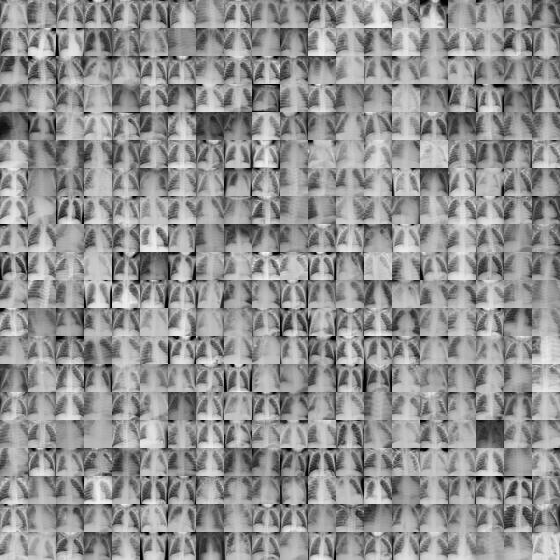

In [4]:
train_dataset.montage()

In [5]:
# Standardize the data.
mean = np.mean(train_images)
stddev = np.std(train_images)
train_images = (train_images - mean) / stddev
test_images = (test_images - mean) / stddev
validation_images = (validation_images - mean) / stddev

# One-hot encode labels.
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)
validation_labels = to_categorical(validation_labels, num_classes=10)

In [6]:
class L2ComplexityMetric(Metric):
    def __init__(self, name='l2_complexity', **kwargs):
        super(L2ComplexityMetric, self).__init__(name=name, **kwargs)
        self.l2_loss = self.add_weight(name='l2_loss', initializer='zeros')
        self.model = None

    def update_state(self, y_true, y_pred, sample_weight=None):
        if self.model is not None:
            # Calcula a perda de complexidade L2 (regularização L2)
            l2_loss = tf.add_n([tf.nn.l2_loss(weight) for weight in self.model.trainable_weights])
            self.l2_loss.assign_add(l2_loss)

    def result(self):
        return self.l2_loss

    def reset_state(self):  # Altere o nome deste método para reset_state
        # Zera as variáveis acumuladas no início de cada época ou avaliação
        self.l2_loss.assign(0.0)

In [7]:
class categorical_crossentropy_loss(tf.keras.losses.Loss):
    def __init__(self, model=None):
        super(categorical_crossentropy_loss, self).__init__()
        self.model = model

    def call(self, y_true, y_pred):
        ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        return ce_loss

In [8]:
class l2_loss(tf.keras.losses.Loss):
    def __init__(self, model=None):
        super(l2_loss, self).__init__()
        self.model = model

    def call(self, y_true, y_pred):
        l2_loss = tf.add_n([tf.nn.l2_loss(weight) for weight in self.model.trainable_weights])
        return l2_loss

In [9]:
def neural_network():

  # Ignore UserWarning temporarily
  warnings.filterwarnings("ignore", category=UserWarning)
  # Object used to initialize weights.
  initializer = keras.initializers.RandomUniform(minval=-0.1, maxval=0.1)

  # Create a Sequential model.
  # 784 inputs.
  # Two Dense (fully connected) layers with 25 and 10 neurons.
  # tanh as activation function for hidden layer.
  # Logistic (sigmoid) as activation function for output layer.
  model = keras.Sequential([
      keras.layers.Flatten(input_shape=(28, 28)),
      keras.layers.Dense(50, activation='relu',
                        kernel_initializer=initializer,
                        bias_initializer='zeros'),
      keras.layers.Dense(10, activation='softmax',
                        kernel_initializer=initializer,
                        bias_initializer='zeros')])

  return model

In [10]:
def build_model(model=None):

  if model==None:
    model = neural_network()

  #Instancie a classe de perda personalizada.
  custom_loss = categorical_crossentropy_loss()
  custom_loss.model = model  # Associando o modelo à função de perda.

  # Criar uma instância da métrica personalizada
  l2_metric = L2ComplexityMetric()
  l2_metric.model = model  # Adicione esta linha para passar a referência do modelo para a métrica

  opt = keras.optimizers.Adam()

  model.compile(loss=custom_loss, optimizer = opt, metrics=['categorical_crossentropy', l2_metric, 'accuracy'])

  # Definindo o callback para salvar o melhor modelo
  checkpoint = ModelCheckpoint('best_model.h5', monitor='categorical_crossentropy', verbose=0, save_best_only=True, mode='min')

  return model, checkpoint

In [11]:
def rebuild_model(model=None):

  if model==None:
    model = neural_network()

  #Instancie a classe de perda personalizada.
  custom_loss = l2_loss()
  custom_loss.model = model  # Associando o modelo à função de perda.

  # Criar uma instância da métrica personalizada
  l2_metric = L2ComplexityMetric()
  l2_metric.model = model  # Adicione esta linha para passar a referência do modelo para a métrica

  opt = keras.optimizers.Adam()

  model.compile(loss=custom_loss, optimizer = opt, metrics=['categorical_crossentropy', l2_metric, 'accuracy'])

  # Definindo o callback para salvar o melhor modelo
  checkpoint = ModelCheckpoint('best_model.h5', monitor='l2_complexity', verbose=0, save_best_only=True, mode='min')

  return model, checkpoint

In [12]:
def clonning(old_model, changed):

  new_model = clone_model(old_model)
  new_model.set_weights(old_model.get_weights())

  if not changed:
    model, checkpoint = build_model(new_model)
  else:
    model, checkpoint = rebuild_model(new_model)

  return model, checkpoint

In [13]:
N = 33
tolerances = np.linspace(14.3, 16.5, N, endpoint=True)
training_times, ce_values, l2_values, coordenates_values, accuracy_values, best_ce_loss_values, best_L2_loss_values  = [], [], [], [], [], [], []

In [14]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
for i in range(N):

  best_ce_loss, best_L2_loss  = float('inf'), float('inf')
  upgrading = 0
  tolerance = tolerances[i]
  coordenates = [0, 0]
  changed = False
  first_run = True

  print("model", i+1, "- relative tolerance", tolerance, ":")

  current_model, checkpoint = build_model()
  best_model, checkpoint = build_model()

  start_time = time.time()

  while upgrading < 4:

      current_model, checkpoint = clonning(best_model, changed)
      training_history = current_model.fit(train_images, train_labels, validation_data=(validation_images, validation_labels), epochs=1, batch_size=32, verbose=1, callbacks=[checkpoint])

      current_L2 = training_history.history["val_l2_complexity"][0]
      current_CE = training_history.history["val_categorical_crossentropy"][0]

      if (current_CE<best_ce_loss and not changed) or first_run:
        print("Best so far")
        first_run = False
        coordenates[0] += 1
        best_model, checkpoint = clonning(current_model, changed)
        best_ce_loss = current_CE
        best_L2_loss = current_L2
        upgrading = 0
      elif(current_CE<best_ce_loss*(1 + tolerance) and current_L2<best_L2_loss and changed):
        print("Best so far")
        coordenates[1] += 1
        best_model, checkpoint = clonning(current_model, changed)
        best_L2_loss = current_L2
        upgrading = 2
      else:
        upgrading += 1

      if upgrading==2 and not changed:
        best_model, checkpoint = rebuild_model(best_model)
        current_model, checkpoint = rebuild_model(best_model)
        print("loss function changed")
        changed = True

  end_time = time.time()
  delta_time = end_time - start_time
  training_times.append(delta_time)

  metrics = best_model.evaluate(test_images, test_labels)
  ce_values.append(metrics[1])
  l2_values.append(metrics[2])
  accuracy_values.append(metrics[3])

  coordenates_values.append(coordenates)

  best_ce_loss_values.append(best_ce_loss)
  best_L2_loss_values.append(best_L2_loss)

  print("best categorical cross entropy:", best_ce_loss)
  print("best L2:", best_L2_loss)
  print("training time:", delta_time, "s")
  print("best model coordenates:", coordenates)
  print("\n")

model 1 - relative tolerance 14.3 :
148/148 [==============================] - 1s 3ms/step - loss: 0.2355 - categorical_crossentropy: 0.2355 - l2_complexity: 10315.0811 - accuracy: 0.9191 - val_loss: 0.1337 - val_categorical_crossentropy: 0.1337 - val_l2_complexity: 1205.7080 - val_accuracy: 0.9447
Best so far
148/148 [==============================] - 1s 3ms/step - loss: 0.1303 - categorical_crossentropy: 0.1303 - l2_complexity: 10700.6406 - accuracy: 0.9516 - val_loss: 0.1336 - val_categorical_crossentropy: 0.1336 - val_l2_complexity: 1250.4580 - val_accuracy: 0.9447
Best so far
148/148 [==============================] - 2s 6ms/step - loss: 0.1158 - categorical_crossentropy: 0.1158 - l2_complexity: 11131.7451 - accuracy: 0.9575 - val_loss: 0.1370 - val_categorical_crossentropy: 0.1370 - val_l2_complexity: 1303.1473 - val_accuracy: 0.9447
loss function changed
20/20 [==============================] - 0s 2ms/step - loss: 73.5564 - categorical_crossentropy: 0.4738 - l2_complexity: 1471.

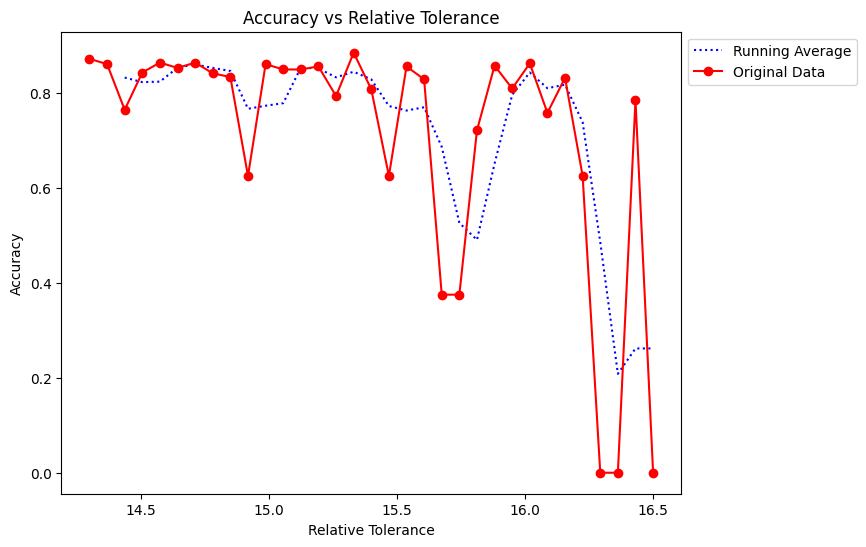

In [15]:
# Convert the list to a NumPy array for easier manipulation
accuracy_values_array = np.array(accuracy_values)

# Calculate the running average with a window size of 3 (adjust as needed)
window_size = 3
running_avg = np.convolve(accuracy_values_array, np.ones(window_size)/window_size, mode='valid')

# Plot the original data and the running average
plt.figure(figsize=(8, 6))
plt.plot(tolerances[window_size-1:], running_avg, color='blue', linestyle=':', label='Running Average')
plt.plot(tolerances, accuracy_values_array, marker='o', color='red', label='Original Data')
plt.xlabel('Relative Tolerance')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Relative Tolerance')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

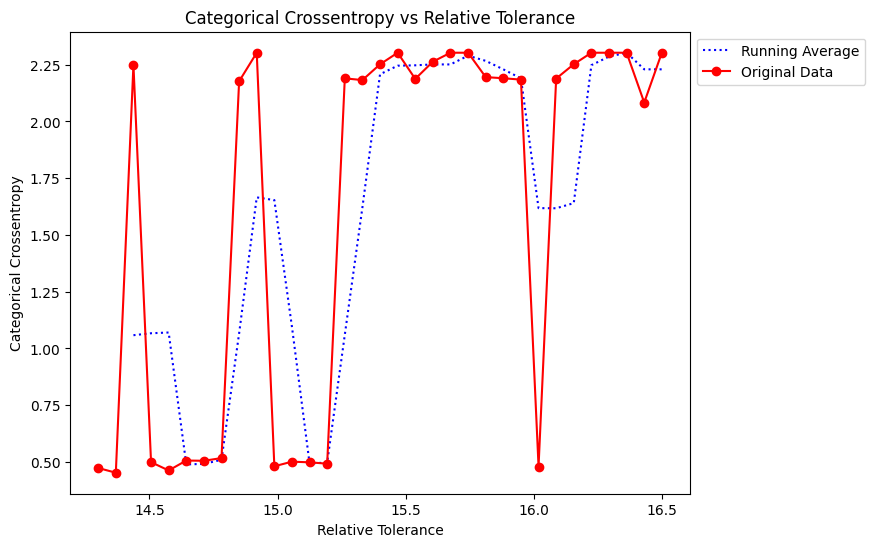

In [16]:
# Convert the list to a NumPy array for easier manipulation
ce_values_array = np.array(ce_values)

# Calculate the running average with a window size of 3 (adjust as needed)
window_size = 3
running_avg = np.convolve(ce_values_array, np.ones(window_size)/window_size, mode='valid')

# Plot the original data and the running average
plt.figure(figsize=(8, 6))
plt.plot(tolerances[window_size-1:], running_avg, color='blue', linestyle=':', label='Running Average')
plt.plot(tolerances, ce_values_array, marker='o', color='red', label='Original Data')
plt.xlabel('Relative Tolerance')
plt.ylabel('Categorical Crossentropy')
plt.title('Categorical Crossentropy vs Relative Tolerance')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

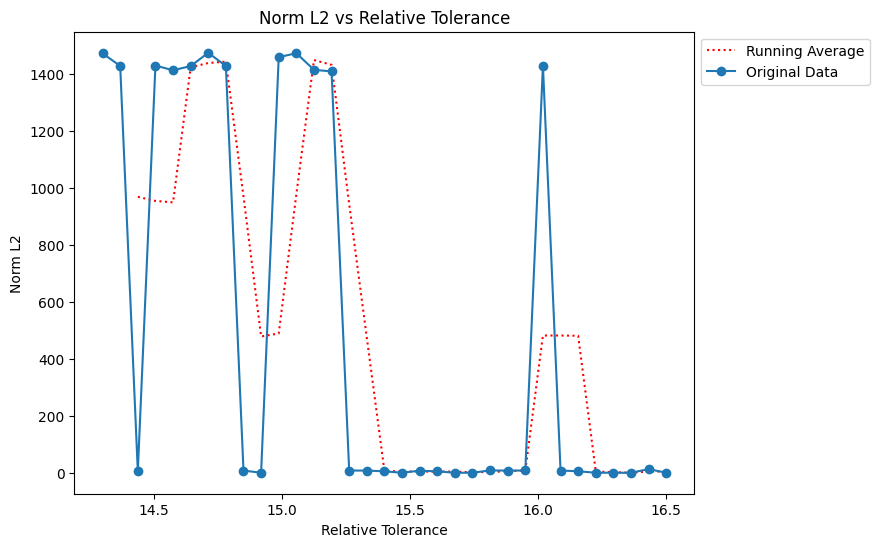

In [17]:
# Convert the list to a NumPy array for easier manipulation
l2_values_array = np.array(l2_values)

# Calculate the running average with a window size of 3 (adjust as needed)
window_size = 3
running_avg = np.convolve(l2_values_array, np.ones(window_size)/window_size, mode='valid')

# Plot the 2D graph
plt.figure(figsize=(8, 6))
plt.plot(tolerances[window_size-1:], running_avg, color='red', linestyle=':', label='Running Average')
plt.plot(tolerances, l2_values_array, marker='o', label='Original Data')
plt.xlabel('Relative Tolerance')
plt.ylabel('Norm L2')
plt.title('Norm L2 vs Relative Tolerance')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

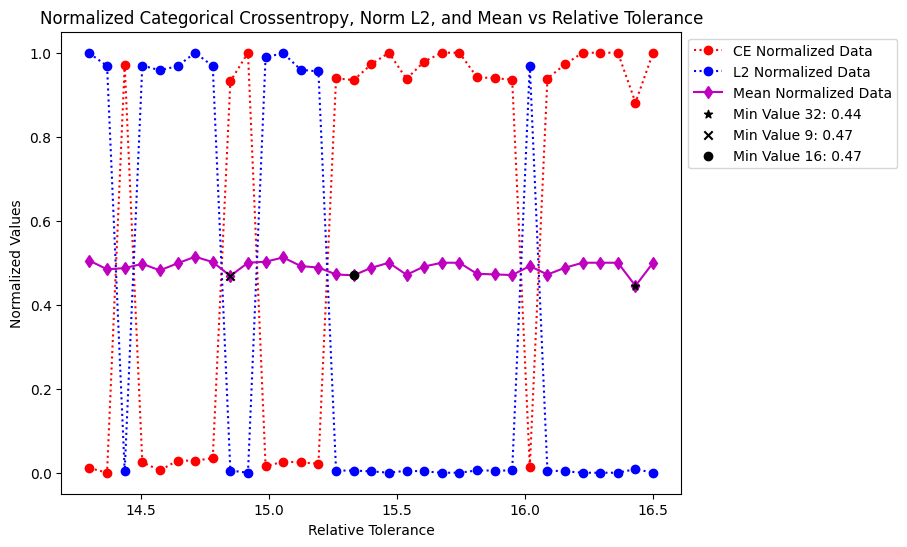

In [18]:
# Convert the lists to NumPy arrays for easier manipulation
ce_values_array = np.array(ce_values)
l2_values_array = np.array(l2_values)

# Normalize the data between 0 and 1
scaler = MinMaxScaler()
ce_normalized = scaler.fit_transform(ce_values_array.reshape(-1, 1)).flatten()
l2_normalized = scaler.fit_transform(l2_values_array.reshape(-1, 1)).flatten()

# Calculate the mean after normalization
mean_normalized = (ce_normalized + l2_normalized) / 2.0

# Find the indices of the three smallest values of mean_normalized
min_indices = np.argsort(mean_normalized)[:3]
min_values = mean_normalized[min_indices]

# Define marcadores para os três pontos mínimos em ordem crescente
markers = ['*', 'x', 'o']

# Plot the combined graph
plt.figure(figsize=(8, 6))

# Plot Categorical Crossentropy
plt.plot(tolerances, ce_normalized, marker='o', color='red', linestyle=':', label='CE Normalized Data')

# Plot Norm L2
plt.plot(tolerances, l2_normalized, marker='o', color='blue', linestyle=':', label='L2 Normalized Data')

# Plot the mean of CE and L2
plt.plot(tolerances, mean_normalized, marker='d', color='m', label='Mean Normalized Data')

# Highlight the points with the three smallest values using different markers
for value, marker in zip(min_values, markers):
    plt.scatter(tolerances[min_indices[np.where(min_values == value)]], value, color='black', zorder=5, marker=marker)

# Create legend labels for the three smallest values
legend_labels_min_values = [f'Min Value {min_indices[i]+1}: {min_values[i]:.2f} ' for i in range(3)]

# Create legend labels including the values of the three smallest mean_normalized
legend_labels = ['CE Normalized Data', 'L2 Normalized Data', 'Mean Normalized Data']
legend_labels.extend(legend_labels_min_values)

plt.xlabel('Relative Tolerance')
plt.ylabel('Normalized Values')
plt.title('Normalized Categorical Crossentropy, Norm L2, and Mean vs Relative Tolerance')

# Adjust legend position to be outside the plot
plt.legend(legend_labels, loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

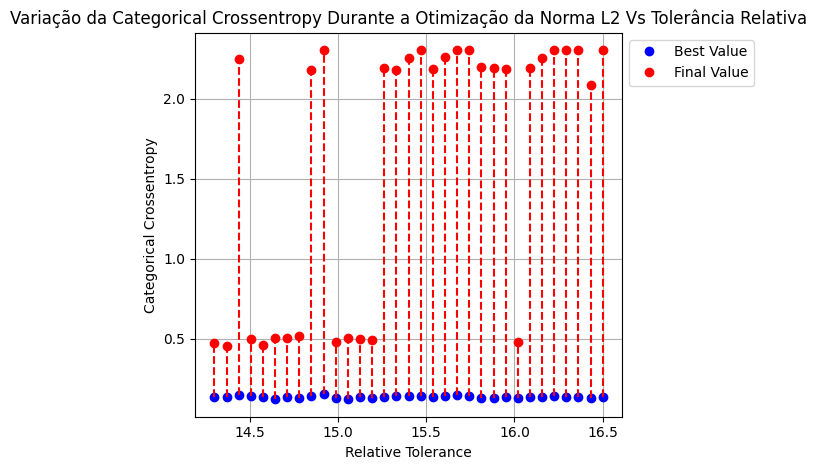

In [19]:
# Valores de x e y
x_values = tolerances
y1_values = best_ce_loss_values
y2_values = ce_values

# Plotar o gráfico de pontos
plt.plot(x_values, y1_values, 'bo', label='Best Value')
plt.plot(x_values, y2_values, 'ro', label='Final Value')

# Conectar os pontos com uma linha
for i in range(len(x_values)):
    if y2_values[i] > y1_values[i]:
        plt.plot([x_values[i], x_values[i]], [y1_values[i], y2_values[i]], 'r--')
    elif y2_values[i] < y1_values[i]:
        plt.plot([x_values[i], x_values[i]], [y1_values[i], y2_values[i]], 'g--')

plt.xlabel('Relative Tolerance')
plt.ylabel('Categorical Crossentropy')
plt.title('Variação da Categorical Crossentropy Durante a Otimização da Norma L2 Vs Tolerância Relativa')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

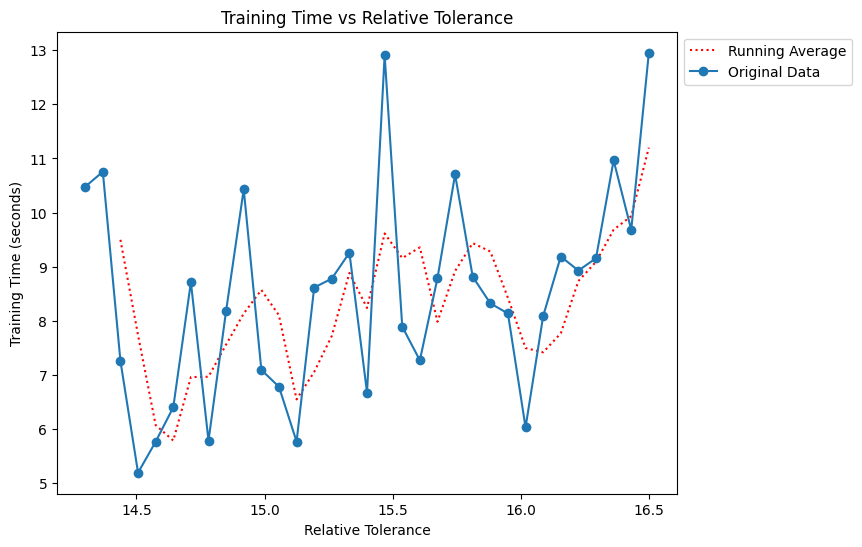

In [20]:
# Convert the list to a NumPy array for easier manipulation
training_times_array = np.array(training_times)

# Calculate the running average with a window size of 3 (adjust as needed)
window_size = 3
running_avg = np.convolve(training_times_array, np.ones(window_size)/window_size, mode='valid')

# Plot the 2D graph
plt.figure(figsize=(8, 6))
plt.plot(tolerances[window_size-1:], running_avg, color='red', linestyle=':', label='Running Average')
plt.plot(tolerances, training_times_array, marker='o', label='Original Data')
plt.xlabel('Relative Tolerance')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time vs Relative Tolerance')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

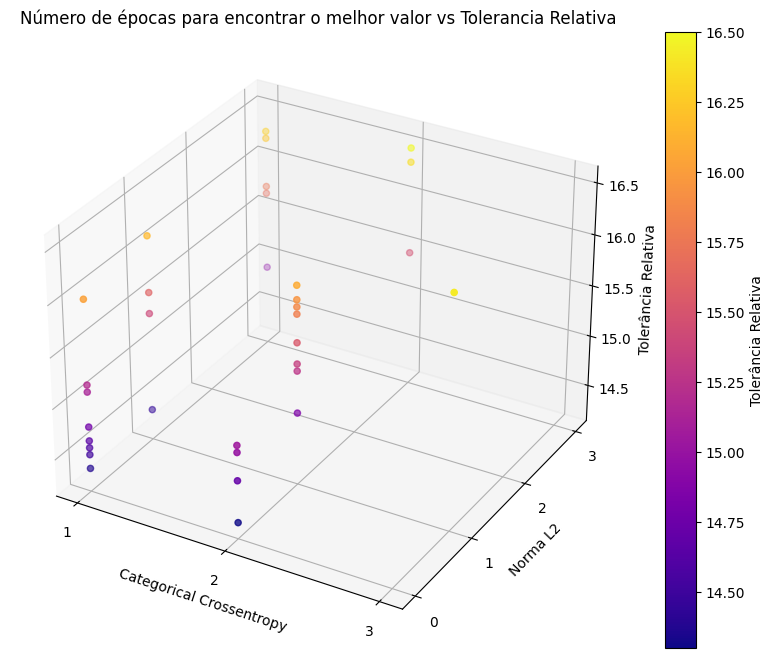

In [21]:
# Gerando pontos 3D
x = np.array([point[0] for point in coordenates_values])
y = np.array([point[1] for point in coordenates_values])
z = np.array(tolerances)

# Definindo cores com base na tolerância (ou qualquer outra variável)
colors = z

# Plotando
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, y, z, c=colors, cmap='plasma')  # Usando cmap='plasma' para um gradiente de cores diferente

plt.title('Número de épocas para encontrar o melhor valor vs Tolerancia Relativa')
ax.set_xlabel('Categorical Crossentropy')
ax.set_ylabel('Norma L2')
ax.set_zlabel('Tolerância Relativa')

# Definindo intervalos para os eixos x e y
ax.set_xticks(np.arange(min(x), max(x)+1, 1))
ax.set_yticks(np.arange(min(y), max(y)+1, 1))

# Adicionando barra de cores
plt.colorbar(sc, label='Tolerância Relativa')

plt.show()

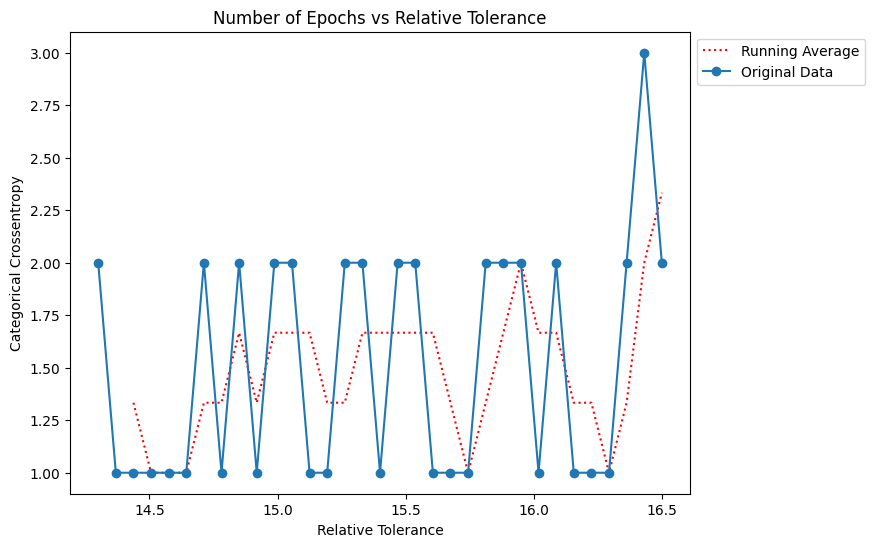

In [22]:
# Calculate the running average with a window size of 3 (adjust as needed)
window_size = 3
running_avg = np.convolve(x, np.ones(window_size)/window_size, mode='valid')

# Plot the 2D graph
plt.figure(figsize=(8, 6))
plt.plot(tolerances[window_size-1:], running_avg, color='red', linestyle=':', label='Running Average')
plt.plot(tolerances, x, marker='o', label='Original Data')
plt.xlabel('Relative Tolerance')
plt.ylabel('Categorical Crossentropy')
plt.title('Number of Epochs vs Relative Tolerance')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

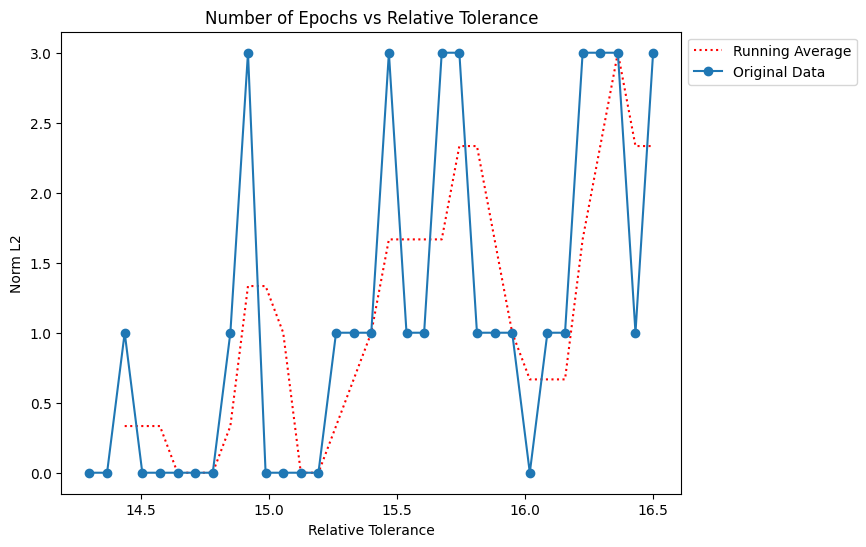

In [23]:

# Calculate the running average with a window size of 3 (adjust as needed)
window_size = 3
running_avg = np.convolve(y, np.ones(window_size)/window_size, mode='valid')

# Plot the 2D graph
plt.figure(figsize=(8, 6))
plt.plot(tolerances[window_size-1:], running_avg, color='red', linestyle=':', label='Running Average')
plt.plot(tolerances, y, marker='o', label='Original Data')
plt.xlabel('Relative Tolerance')
plt.ylabel('Norm L2')
plt.title('Number of Epochs vs Relative Tolerance')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

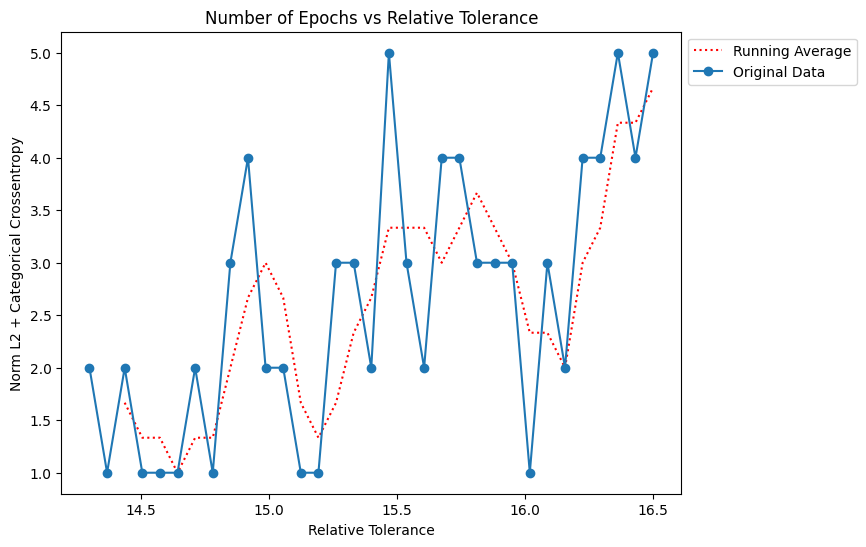

In [24]:
sum = x + y

# Calculate the running average with a window size of 3 (adjust as needed)
window_size = 3
running_avg = np.convolve(sum, np.ones(window_size)/window_size, mode='valid')

# Plot the 2D graph
plt.figure(figsize=(8, 6))
plt.plot(tolerances[window_size-1:], running_avg, color='red', linestyle=':', label='Running Average')
plt.plot(tolerances, sum, marker='o', label='Original Data')
plt.xlabel('Relative Tolerance')
plt.ylabel('Norm L2 + Categorical Crossentropy')
plt.title('Number of Epochs vs Relative Tolerance')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [25]:
def sort_models(CE, L2, Time, Tol, AC, min_indices):
    num_models = len(CE)
    decimal_places = 2

    while True:
        # Ordenar os modelos de acordo com a Categorical Crossentropy
        indices = sorted(range(num_models), key=lambda i: (round(CE[i], decimal_places), round(L2[i], decimal_places), round(Time[i], decimal_places)))

        # Verificar se há empates
        is_tie = False
        for i in range(1, num_models):
            if CE[indices[i]] == CE[indices[i - 1]] and \
               L2[indices[i]] == L2[indices[i - 1]] and \
               Time[indices[i]] == Time[indices[i - 1]]:
                is_tie = True
                break

        # Se não houver empates, terminar o loop
        if not is_tie:
            break

        # Aumentar as casas decimais em caso de empate
        decimal_places += 1

    # Imprimir os modelos ordenados
    for i, idx in enumerate(indices):
        print(f'{i+1}º:')
        print(f' - Model {min_indices[idx]+1}: (Relative Tolerance={Tol[idx]}; Accuracy={AC[idx]})')
        print(f'   + Categorical Crossentropy: {CE[idx]}')
        print(f'   + Norm L2: {L2[idx]}')
        print(f'   + Training Time (seconds): {Time[idx]}')
        print()

    return Tol[0]

In [26]:
CE, L2, Time, Tol, AC = [], [], [], [], []

for i in range(len(min_indices)):
 CE.append(ce_values_array[min_indices[i]])
 L2.append(l2_values_array[min_indices[i]])
 Time.append(training_times_array[min_indices[i]])
 Tol.append(tolerances[min_indices[i]])
 AC.append(accuracy_values_array[min_indices[i]])

Best_Tolerance = sort_models(CE, L2, Time, Tol, AC, min_indices)

1º:
 - Model 32: (Relative Tolerance=16.43125; Accuracy=0.7852563858032227)
   + Categorical Crossentropy: 2.083155870437622
   + Norm L2: 12.574808120727539
   + Training Time (seconds): 9.681779146194458

2º:
 - Model 9: (Relative Tolerance=14.850000000000001; Accuracy=0.8333333134651184)
   + Categorical Crossentropy: 2.1766395568847656
   + Norm L2: 7.56373405456543
   + Training Time (seconds): 8.187946081161499

3º:
 - Model 16: (Relative Tolerance=15.33125; Accuracy=0.8846153616905212)
   + Categorical Crossentropy: 2.182124376296997
   + Norm L2: 7.575129985809326
   + Training Time (seconds): 9.25894808769226



In [27]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

best_ce_loss, best_L2_loss  = float('inf'), float('inf')
upgrading = 0
tolerance = Best_Tolerance
changed = False
first_run = True

current_model, checkpoint = build_model()
best_model, checkpoint = build_model()

while upgrading < 4:

    current_model, checkpoint = clonning(best_model, changed)
    training_history = current_model.fit(train_images, train_labels, validation_data=(validation_images, validation_labels), epochs=1, batch_size=32, verbose=1, callbacks=[checkpoint])

    current_L2 = training_history.history["val_l2_complexity"][0]
    current_CE = training_history.history["val_categorical_crossentropy"][0]

    if (current_CE<best_ce_loss and not changed) or first_run:
      print("Best so far")
      first_run = False
      coordenates[0] += 1
      best_model, checkpoint = clonning(current_model, changed)
      best_ce_loss = current_CE
      best_L2_loss = current_L2
      upgrading = 0
    elif(current_CE<best_ce_loss*(1 + tolerance) and current_L2<best_L2_loss and changed):
      print("Best so far")
      coordenates[1] += 1
      best_model, checkpoint = clonning(current_model, changed)
      best_L2_loss = current_L2
      upgrading = 2
    else:
      upgrading += 1

    if upgrading==2 and not changed:
      best_model, checkpoint = rebuild_model(best_model)
      current_model, checkpoint = rebuild_model(best_model)
      print("loss function changed")
      changed = True

148/148 [==============================] - 1s 3ms/step - loss: 0.2220 - categorical_crossentropy: 0.2220 - l2_complexity: 10304.3916 - accuracy: 0.9216 - val_loss: 0.1334 - val_categorical_crossentropy: 0.1334 - val_l2_complexity: 1205.9199 - val_accuracy: 0.9523
Best so far
148/148 [==============================] - 1s 3ms/step - loss: 0.1255 - categorical_crossentropy: 0.1255 - l2_complexity: 10714.8252 - accuracy: 0.9548 - val_loss: 0.1362 - val_categorical_crossentropy: 0.1362 - val_l2_complexity: 1253.5135 - val_accuracy: 0.9427
loss function changed
148/148 [==============================] - 1s 3ms/step - loss: 14.7110 - categorical_crossentropy: 1.1992 - l2_complexity: 2093.8997 - accuracy: 0.9582 - val_loss: 0.2472 - val_categorical_crossentropy: 2.2518 - val_l2_complexity: 4.2026 - val_accuracy: 0.9504
Best so far
148/148 [==============================] - 1s 3ms/step - loss: 0.0098 - categorical_crossentropy: 2.3014 - l2_complexity: 1.1879 - accuracy: 0.2332 - val_loss: 2.370

In [28]:
metrics = best_model.evaluate(test_images, test_labels)

20/20 [==============================] - 0s 1ms/step - loss: 1.0849e-09 - categorical_crossentropy: 2.3026 - l2_complexity: 2.1697e-08 - accuracy: 0.0000e+00


In [29]:
best_model.save('best_model.h5')